In [30]:
import pandas as pd
import matplotlib.pyplot as plt

1\. **Pandas DataFrame**

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every `x` BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [5]:
# If haven't downloaded it yet, please get the data file with wget
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [6]:
# Setting file path
file_path = 'data_000637.txt'

# Reading the first N rows
N = 15000

# Read the data with Pandas
df = pd.read_csv(file_path, nrows=N)

#Printing the collected data 
print(df)

       HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS
0         1     0          123  3869200167        2374        26
1         1     0          124  3869200167        2374        27
2         1     0           63  3869200167        2553        28
3         1     0           64  3869200167        2558        19
4         1     0           64  3869200167        2760        25
...     ...   ...          ...         ...         ...       ...
14995     1     1            4  3869200316        3399         9
14996     1     1           17  3869200316        3400        15
14997     1     1           10  3869200316        3530        16
14998     1     1            8  3869200316        3533        18
14999     1     0          139  3869200316        3539         0

[15000 rows x 6 columns]


2\. Estimate the number of BX in a ORBIT (the value `x`).

*Hint*: check when the BX counter reaches the maximum value before being reset to 0.

In [7]:
# Identify when BX counter reaches maximum
max_bx = df['BX_COUNTER'].max()

# Count the number of ORBITs
orbit_count = df[df['BX_COUNTER'] == 0].shape[0]

# Estimate x based on observations
estimated_x = max_bx * orbit_count

print(f"Estimated number of BX in an ORBIT (x): {estimated_x}")


Estimated number of BX in an ORBIT (x): 24941


3\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition, and convert the new column to a Time Series.

*Hint:* introduce an offset to the absolute time such that the start of the data acquisition (i.e. the first entry) is zero.

In [17]:
# Create a new column with the absolute time as an addition of the three columns, in ns
df['ABS_TIME_NS'] = ( df['ORBIT_CNT']  + df['BX_COUNTER'] + df['TDC_MEAS'])

# Set the offset to the start
offset = df['ABS_TIME_NS'].min()
df['ABS_TIME_NS'] -= offset

# Convert the new column to time series
df['ABS_TIME_NS'] = pd.to_datetime(df['ABS_TIME_NS'], unit='ns')

# Printing the dataframe
print(df)


         HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS  \
0           1     0          123  3869200167        2374        26   
1           1     0          124  3869200167        2374        27   
2           1     0           63  3869200167        2553        28   
3           1     0           64  3869200167        2558        19   
4           1     0           64  3869200167        2760        25   
...       ...   ...          ...         ...         ...       ...   
1310715     1     0           62  3869211171         762        14   
1310716     1     1            4  3869211171         763        11   
1310717     1     0           64  3869211171         764         0   
1310718     1     0          139  3869211171         769         0   
1310719     1     0           61  3869211171         762        18   

                          ABS_TIME_NS  
0       1970-01-01 00:00:00.000002379  
1       1970-01-01 00:00:00.000002380  
2       1970-01-01 00:00:00.000002560  

4\. Find out the duration of the data taking in hours, minutes and seconds, by using the features of the Time Series. Perform this check reading the whole dataset.

In [23]:
#Finding the duration 
duration = df['ABS_TIME_NS'].max() - df['ABS_TIME_NS'].min()

#Extracting the hours, minutes, and seconds
hours = duration.total_seconds() // 3600
minutes = (duration.total_seconds() % 3600) // 60 
seconds = duration.total_seconds() % 60

print(f"Duration of data taking: {hours} hours, {minutes} minutes, {seconds} seconds")

1970-01-01 00:00:00.000014562
1970-01-01 00:00:00
Duration of data taking: 0.0 hours, 0.0 minutes, 1.4e-05 seconds


5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [24]:
# Grouping by TDC_CHANNEL and count occurrences
channel_counts = df.groupby('TDC_CHANNEL').size()

# Finding the top 3 noisy channels
top_noisy_channels = channel_counts.nlargest(3)

# Printing the result
print("Top 3 Noisy Channels:")
print(top_noisy_channels)

Top 3 Noisy Channels:
TDC_CHANNEL
139    108059
64      66020
63      64642
dtype: int64


6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit).

In [28]:
# Count the number of orbits with at least one hit
non_empty_orbits_count = df['ORBIT_CNT'].nunique()

# Print the result
print(f"Number of non-empty orbits (with at least one hit): {non_empty_orbits_count}")


Number of non-empty orbits (with at least one hit): 11001


7\. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [ ]:
# Filtering rows where TDC_CHANNEL is 139
filtered_df = df[df['TDC_CHANNEL'] == 139]

# Counting the number of unique orbits in the filtered DataFrame
unique_orbits_count = filtered_df['ORBIT_CNT'].nunique()

# Printing the result
print(f"Number of unique orbits with at least one measurement from TDC_CHANNEL=139: {unique_orbits_count}")


8\. Create two Series (one for each FPGA) that have the TDC channel as index, and the number of counts for the corresponding TDC channel as values.

In [29]:
# Grouping by FPGA and TDC_CHANNEL and count occurrences
fpga_channel_counts = df.groupby(['FPGA', 'TDC_CHANNEL']).size()

# Separating the counts for each FPGA
fpga_counts_0 = fpga_channel_counts.loc[0]
fpga_counts_1 = fpga_channel_counts.loc[1]

# Converting to Series with TDC_CHANNEL as index
fpga0_series = pd.Series(fpga_counts_0.values, index=fpga_counts_0.index.get_level_values('TDC_CHANNEL'))
fpga1_series = pd.Series(fpga_counts_1.values, index=fpga_counts_1.index.get_level_values('TDC_CHANNEL'))

# Printing the result
print("FPGA 0 Series:")
print(fpga0_series)

print("\nFPGA 1 Series:")
print(fpga1_series)


FPGA 0 Series:
TDC_CHANNEL
1       1215
2       1602
3       1493
4       2352
5       1432
       ...  
129        2
130       33
137       32
138       34
139    75617
Length: 124, dtype: int64

FPGA 1 Series:
TDC_CHANNEL
1      28438
2      32669
3      21970
4      26403
5      15003
       ...  
129       35
130       38
137       36
138       36
139    32442
Length: 132, dtype: int64


9\. **Optional:** Create two histograms (one for each FPGA) that show the number of counts for each TDC channel.

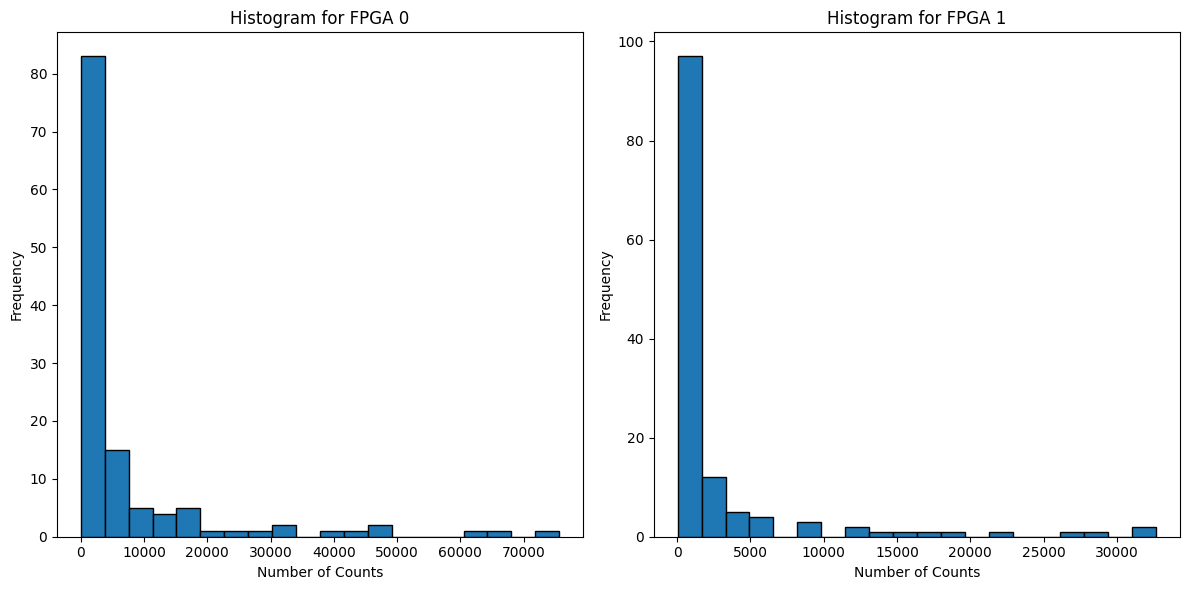

In [31]:
# Plot histograms for each FPGA
plt.figure(figsize=(12, 6))

# Creating histogram for FPGA 0
plt.subplot(1, 2, 1)
plt.hist(fpga_counts_0, bins=20, edgecolor='black')
plt.title('Histogram for FPGA 0')
plt.xlabel('Number of Counts')
plt.ylabel('Frequency')

# Creating Histogram for FPGA 1
plt.subplot(1, 2, 2)
plt.hist(fpga_counts_1, bins=20, edgecolor='black')
plt.title('Histogram for FPGA 1')
plt.xlabel('Number of Counts')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()
